# Modeling - Logistic Regression
In this notebook, I have created a Logistic Regression Model for predicting churn for an ISP.

## Table of Contents:
1. Data Loading
2. Checking for Assumptions of Logistic Regression
    - Categorical Target
    - Independence of Observations
    - Linear relationship between numerical variables and log odds of target
    - Absence of Multicollinearity
3. Modeling without Transformation
4. Modeling with QuantileTransformer

In [1]:
# Importing required libraries and modules
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [2]:
# Setting seaborn figure size
sns.set(rc={'figure.figsize':(10,8)})

## Data Loading

In [3]:
train_prepared = pd.read_csv('../data/processed/train-prepared.csv')

In [4]:
print('Shape=>', train_prepared.shape)
train_prepared.head()

Shape=> (62273, 11)


,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,1,1.77,7,0.19,1,0,114.1,8.7,0,0
1,1,0,0.05,6,0.59,1,0,12.7,1.3,0,0
2,0,0,1.42,18,0.00,0,0,0.4,0.0,0,1
3,1,0,0.73,20,0.00,1,0,9.3,0.4,0,1
4,1,0,0.25,17,0.00,1,0,6.1,0.5,0,1


In [5]:
# Getting an overview of the dataset
train_prepared.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62273 entries, 0 to 62272
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             62273 non-null  int64  
 1   is_movie_package_subscriber  62273 non-null  int64  
 2   subscription_age             62273 non-null  float64
 3   bill_avg                     62273 non-null  int64  
 4   remaining_contract           62273 non-null  float64
 5   is_contract                  62273 non-null  int64  
 6   service_failure_count        62273 non-null  int64  
 7   download_avg                 61948 non-null  float64
 8   upload_avg                   61948 non-null  float64
 9   download_over_limit          62273 non-null  int64  
 10  churn                        62273 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 5.2 MB


## Checking for Assumptions of Logistic Regression

### 1. Categorical Target
The target is *churn* column which is a binary variable. Therefore, 1st assumption holds true for our data.

### 2. Independence of Observations
The internet usage and subscription of one user is not affected by other users. Therefore, 2nd assumption also holds.

### 3. Linear relationship between numerical variables and log odds of target
The relationship between numerical variables and log odds of *churn=1* should be a linear one.

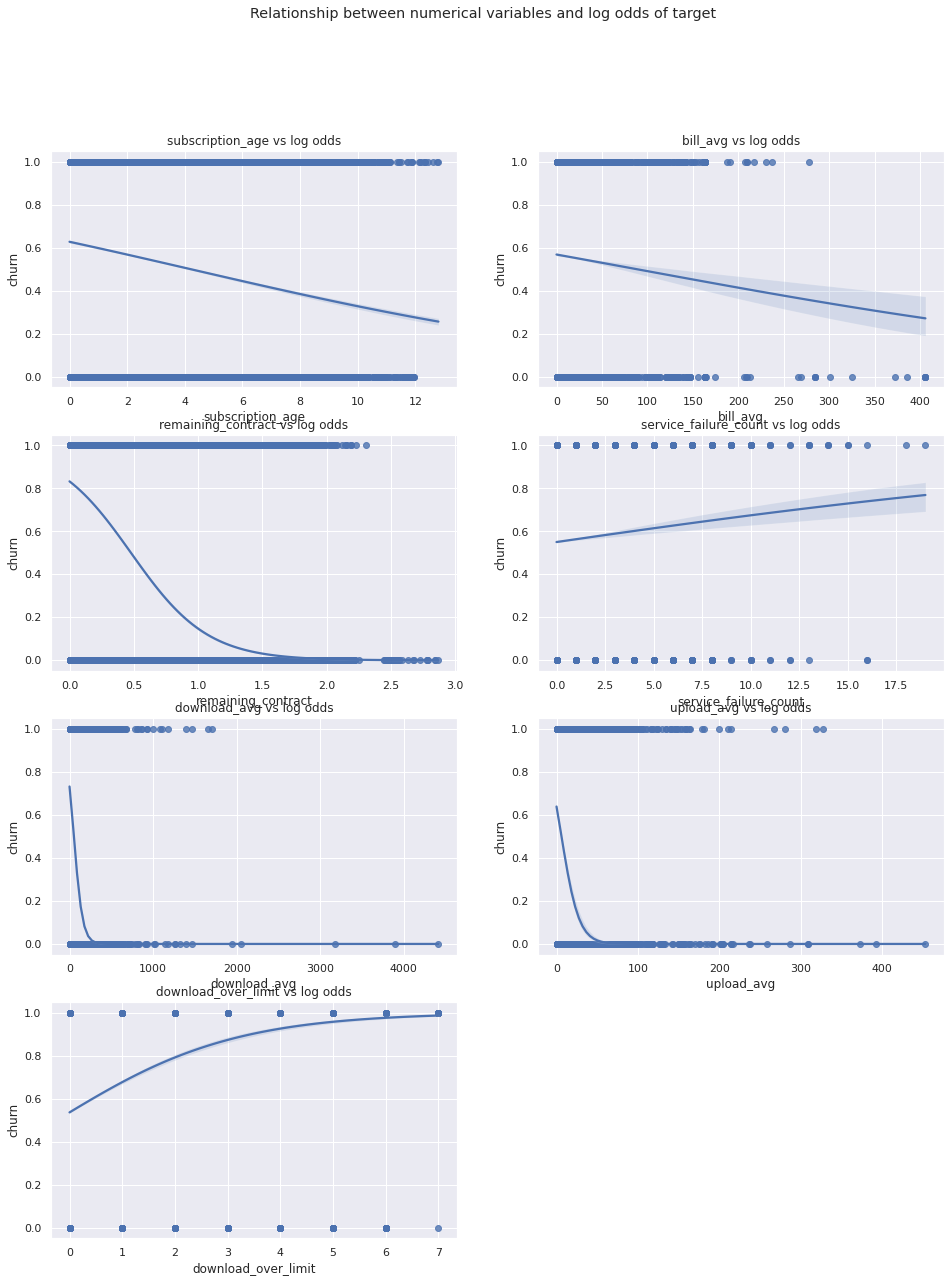

In [6]:
fig, axes = plt.subplots(4,2, figsize=(16, 20))
fig.delaxes(axes[3,1])
fig.suptitle('Relationship between numerical variables and log odds of target')

numerical_cols = ['subscription_age', 'bill_avg', 'remaining_contract',
                  'service_failure_count', 'download_avg', 'upload_avg',
                  'download_over_limit']

for ax, col in zip(axes.flatten(), numerical_cols):
    sns.regplot(x=f'{col}',
                y='churn',
                data=train_prepared,
                ax=ax,
                logistic=True, seed=42).set_title(f"{col} vs log odds")

plt.show()

### 4. Absence of Multicollinearity
We can check this using the VIF(Variance Inflation Factor). If a feature has VIF > 10 then, it indicates multicollinearity.

In [7]:
X = train_prepared.loc[:, train_prepared.columns != 'churn']

# Creating a dataframe for storing VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

In [8]:
# Imputing null values with median
imputer = SimpleImputer(strategy='median')
imputer.fit(X)
X=imputer.transform(X)

In [9]:
# Computing VIF for predictors
vif_data['vif'] = [variance_inflation_factor(X, i) for i in range(10)]

In [10]:
vif_data

,feature,vif
0,is_tv_subscriber,4.947096
1,is_movie_package_subscriber,1.875925
2,subscription_age,2.323774
3,bill_avg,3.065352
4,remaining_contract,2.276598
5,is_contract,4.169998
6,service_failure_count,1.124501
7,download_avg,2.507009
8,upload_avg,1.745037
9,download_over_limit,1.061599


None of the predictors has VIF > 10, which means we don't have multicollinearity in our dataset.

## Modeling without Transformation
Now, I'll train our Logistic Regression Model without transforming the data and evaluate it using 10 fold cross-validation with AUC-ROC as evaluation metric.

In [11]:
# Separating predictors and target
X, y = train_prepared.loc[:, train_prepared.columns != 'churn'], train_prepared.loc[:, 'churn']

In [12]:
# Defining modeling pipeline
model = LogisticRegression(max_iter=1000, n_jobs=-1)
imputer = SimpleImputer(strategy='median')
pipeline = Pipeline(steps = [('median_imputer', imputer),
                             ('logistic_regression', model)])

In [13]:
# Defining model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [14]:
# Evaluating Model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [15]:
print('Mean AUC-ROC Score of Logistic Regression: %.4f \u00B1 %.4f' % (np.mean(scores), np.std(scores)))

Mean AUC-ROC Score of Logistic Regression: 0.9334 ± 0.0035


## Modeling with QuantileTransformer
It's time to train our Logistic Regression Model with Normal Quantile Transformer and evaluate it using 10 fold cross-validation with AUC-ROC as evaluation metric.

In [16]:
# Defining modeling pipeline
imputer = SimpleImputer(strategy='median')

quantile_transformer = QuantileTransformer(n_quantiles=1000,
                                           output_distribution='normal',
                                           random_state=42)
transformer = ColumnTransformer(transformers=[('quantile_transformer',
                                               quantile_transformer,
                                               [2, 3, 4, 6, 7, 8, 9])],
                                n_jobs=-1,
                                remainder='passthrough')

model = LogisticRegression(max_iter=1000, n_jobs=-1)

pipeline = Pipeline(steps = [('median_imputer', imputer),
                             ('transformer', transformer),
                             ('logistic_regression', model)])

In [17]:
# Defining model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [18]:
# Evaluating Model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [19]:
print('Mean AUC-ROC Score of Logistic Regression: %.4f \u00B1 %.4f' % (np.mean(scores), np.std(scores)))

Mean AUC-ROC Score of Logistic Regression: 0.9624 ± 0.0027
